# STELLARSTRUC.IPYNB -- Solve equations of stellar structure

In [6]:
### IMPORT STUFF ###

import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from crust import crust

G = 6.674e-8 # Newton's constant in cgs units
c = 2.998e10 # speed of light in cm/s
Msun = 1.988e33 # solar mass in g
rhonuc = 2.7e14 # nuclear density in g/cm^3

In [7]:
### DEFINE SOME FUNCTIONS ###

def geteos(eospath,eosname): # import tabulated EoS data
    
    eos = np.genfromtxt(eospath+eosname+".dat") # EoS data (rho=mass density, p=pressure/c^2, mu=total energy density/c^2) in g/cm^3
    [rhodat,mudat,pdat] = crust(eos) # affix low-density crust EoS, return (rho,mu,p) in units of rhonuc

    return [rhodat, mudat, pdat]

def intpeos(rhodat,mudat,pdat): # interpolate full EoS from tabulated data
    
    pmuintp = interp1d(mudat,pdat,kind='linear',bounds_error=False,fill_value=0.)
    dpdmumuintp = interp1d(mudat,np.gradient(pdat)/np.gradient(mudat),kind='linear',bounds_error=False,fill_value=0.)
    
    def p(mu): # pressure as a function of total energy density
        
        return pmuintp(mu)
    
    def dpdmu(mu): # sound speed squared
        
        return dpdmumuintp(mu)
    
    murhointp = interp1d(rhodat,mudat,kind='linear',bounds_error=False,fill_value=0.)
    
    def Mu(rho): # total energy density as a function of rest-mass energy density, for calculating central value of total energy density

        return murhointp(rho)
    
    return [p, dpdmu, Mu]

def hydro(y,r): # condition of hydrostatic equilibrium
        
    mu, m = y
        
    return -(mu+p(mu))*(m+4.*np.pi*r**3*p(mu))/(dpdmu(mu)*r**2*(1.-2.*m/r))
    
def mass(y,r): # defining equation for the mass
    
    mu, m = y
    
    return 4.*np.pi*r**2*mu

def struceqs(y,r): # implement equations of stellar structure as a set of coupled ODEs
     
    return hydro(y,r), mass(y,r)

In [8]:
### PROVIDE INPUT PARAMETERS ###

eosname = "APR4" # SET EQUATION OF STATE HERE
rhoc = 2. # SET CENTRAL MASS DENSITY HERE

eospath = "./" # path to EoS data files
stp = 1e-4 # starting step for numerical integration
pts = 5e3 # number of points at which to evaluate numerical integration
tol = 1e-6 # tolerance for surface finding algorithm

In [9]:
### RUN CODE ###

[rhodat,mudat,pdat] = geteos(eospath,eosname) # get tabulated EoS data in units of rhonuc
[p, dpdmu, Mu] = intpeos(rhodat,mudat,pdat) # interpolate full EoS p(mu), dpdmu(mu), Mu(rho) from tabulated data

muc = Mu(rhoc) # calculate central total energy density from central mass density
y0 = [muc,4.*np.pi*stp**3*muc/3.] # implement boundary conditions at center of star
rlist = np.linspace(stp,10.,int(pts)) # list radial points at which to evaluate numerical integration
ys = np.zeros((len(rlist),2)) # create array to store values of functions at evaluation points

ys[0] = y0 # store central boundary values
Rsol = rlist[-1] # to initialize search, set maximum possible surface location to be furthest radial evaluation point

for i in range(len(rlist)-1): # integrate to each radial evaluation point, check if p = 0, continue if not, break if yes

    rs = [rlist[i],rlist[i+1]] # current integration interval

    y = odeint(struceqs,ys[i],rs) # do numerical integration

    ys[i+1] = y[-1] # save solution for functions
    pressure = ys[i+1][0] # extract pressure

    if (pressure < tol or pressure != pressure): # check if pressure vanishes

        Rsol = rs[0] # if so, define stellar surface to lie at current location

        break

rlist = rlist[0:i+1] # truncate list of radial points at surface r=R
musoldat = ys[0:i+1,0] # record solution for mu(r)
msoldat = ys[0:i+1,1] # record solution for m(r)

musol = interp1d(rlist,musoldat,kind='linear') # interpolate full solution for mu(r) from tabulation
msol = interp1d(rlist,msoldat,kind='linear') # interpolate full solution for m(r) from tabulation
psol = interp1d(rlist,p(musoldat),kind='linear') # interpolate full solution for p(r)=p(mu(r)) from tabulation

Msol = msol(Rsol) # evaluate total mass of star M = m(R)

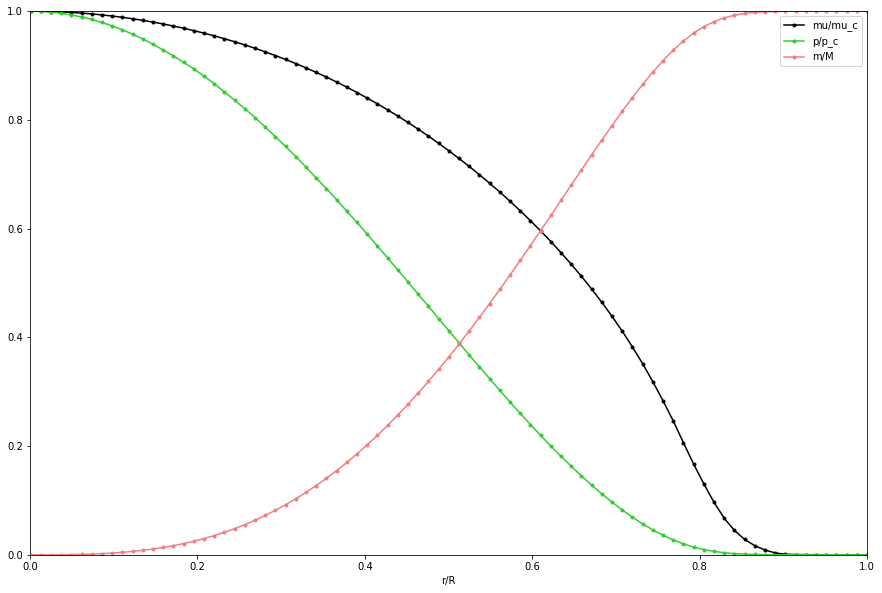

An APR4-star with rho_c = 2.0 rho_nuc has a mass of M = 0.535781822647 M_Sun and a radius of R = 11.5917151563 km.


In [10]:
### OUTPUT RESULTS ###

plt.figure(1,(15,10)) # plot mu(r), p(r), m(r)
plt.plot(rlist/Rsol,musol(rlist)/muc,c='black',marker='.',label='mu/mu_c')
plt.plot(rlist/Rsol,psol(rlist)/p(muc),c='limegreen',marker='.',label='p/p_c')
plt.plot(rlist/Rsol,msol(rlist)/Msol,c='lightcoral',marker='.',label='m/M')
plt.xlabel('r/R')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.legend()
plt.show()

R = Rsol*c/(1e5*(G*rhonuc)**0.5) # convert R from code units to km
M = Msol*c**3/(G*(G*rhonuc)**0.5*Msun) # convert M from code units to solar masses

print 'An {0}-star with rho_c = {1} rho_nuc has a mass of M = {2} M_Sun and a radius of R = {3} km.'.format(eosname,rhoc,M,R)